In [74]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import glob
import os
import scipy.stats as stats

In [68]:
# Define data directory
base_dir = "../results/experiment-001"
# Find all folders (models + control)
model_folders = [f for f in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, f))]


## Trapezoid Rule

We analyze each csv for each model. We use the Trapezoid rule to calculate the Total Energy (Joules) for a specific trial and we repeat 30 Times: Do this for all 30 CSVs in that model's folder. 

In [69]:
# We will store every single trial's final result in this list
all_trials_data = []

print("Processing all CSV files using the Trapezoid Rule...")

for folder in model_folders:
    # Find all 30 CSVs in this folder
    csv_pattern = os.path.join(base_dir, folder, "trial-*.csv")
    csv_files = glob.glob(csv_pattern)
    
    for file in csv_files:
        df = pd.read_csv(file)
        
        # Failsafe: check if the GPU power column exists
        if 'GPU0_POWER (mWatts)' not in df.columns:
            continue
            
        # Convert timestamp to elapsed Seconds (starting from 0)
        time_sec = (df['Time'] - df['Time'].min()) / 1000.0
        
        # Convert milliWatts to standard Watts
        power_watts = df['GPU0_POWER (mWatts)'] / 1000.0
        
        # Calculate Area Under the Curve (Total Joules)
        total_energy_joules = np.trapezoid(y=power_watts, x=time_sec)
        
        # Get the total duration of this specific trial
        total_time_seconds = time_sec.max()
        
        # Store the calculated metrics for THIS trial
        all_trials_data.append({
            'Model': folder,
            'Trial_Name': os.path.basename(file),
            'Total_Energy_Joules': total_energy_joules,
            'Total_Time_Seconds': total_time_seconds
        })

# Convert the master list into a DataFrame
df_results = pd.DataFrame(all_trials_data)

print(f"\nSuccessfully processed {len(df_results)} trials.")
print("\nHere is a sneak peek of the dataset:")
display(df_results.head())

Processing all CSV files using the Trapezoid Rule...

Successfully processed 210 trials.

Here is a sneak peek of the dataset:


,Model,Trial_Name,Total_Energy_Joules,Total_Time_Seconds
0,deepseek-r1_8b-llama-distill-q8_0,trial-026.csv,155.065131,6.205
1,deepseek-r1_8b-llama-distill-q8_0,trial-027.csv,2765.310940,38.820
2,deepseek-r1_8b-llama-distill-q8_0,trial-025.csv,630.366980,11.206
3,deepseek-r1_8b-llama-distill-q8_0,trial-019.csv,685.746083,12.606
4,deepseek-r1_8b-llama-distill-q8_0,trial-018.csv,778.247545,12.607


## Anomalies Detection

Running the following block of code, we identified that 5 out of our 210 executions were anomalous. Four trials reached our 60-second hardware timeout limit and were forcefully aborted, resulting in extreme energy spikes. One trial probably experienced a software crash (terminating in 0.6 seconds). Following standard data-cleaning procedures, these outliers were discarded to prevent skewed distributions. Furthermore, sensor data confirmed that the GPU temperature never exceeded 66°C, validating that our cooling and resting strategy effectively prevented thermal throttling.

In [70]:
print("=== OUTLIER DETECTION REPORT ===\n")
valid_trials = []

# Flag and filter outliers per model
for model in df_results['Model'].unique():
    model_df = df_results[df_results['Model'] == model].copy()
    
    # Calculate Mean and Standard Deviation for Time
    mean_time = model_df['Total_Time_Seconds'].mean()
    std_time = model_df['Total_Time_Seconds'].std()
    
    # We use different rules for the control group vs the AI models
    if model == 'control':
        # For the control group, we filter out extreme crashes and anomalies > 3 standard deviations
        outlier_condition = (
            (model_df['Total_Time_Seconds'] < 1.0) | 
            (np.abs(model_df['Total_Time_Seconds'] - mean_time) > 3 * std_time)
        )
    else:
        # For the AI models, we filter out crashes, timeouts (>= 59s), and anomalies > 3 standard deviations
        outlier_condition = (
            (model_df['Total_Time_Seconds'] < 1.0) | 
            (model_df['Total_Time_Seconds'] >= 59.0) |
            (np.abs(model_df['Total_Time_Seconds'] - mean_time) > 3 * std_time)
        )
    
    outliers = model_df[outlier_condition]
    clean_data = model_df[~outlier_condition]
    valid_trials.append(clean_data)
    
    if not outliers.empty and model != 'control':
        print(f"⚠️ {model} had {len(outliers)} anomalous runs discarded:")
        for _, row in outliers.iterrows():
            print(f"   - {row['Trial_Name']}: Time = {row['Total_Time_Seconds']:.2f}s, Energy = {row['Total_Energy_Joules']:.0f} J")
        print()

# Create your final, clean dataset!
clean_df = pd.concat(valid_trials)

print(f"✅ Data cleaning complete. Retained {len(clean_df)} valid trials out of {len(df_results)} total.")

=== OUTLIER DETECTION REPORT ===

⚠️ deepseek-r1_8b-llama-distill-q8_0 had 2 anomalous runs discarded:
   - trial-001.csv: Time = 59.83s, Energy = 4092 J
   - trial-003.csv: Time = 0.60s, Energy = 8 J

⚠️ llama3.1_8b-instruct-q8_0 had 1 anomalous runs discarded:
   - trial-001.csv: Time = 59.83s, Energy = 4054 J

⚠️ deepseek-r1_8b-llama-distill-fp16 had 1 anomalous runs discarded:
   - trial-025.csv: Time = 59.83s, Energy = 3965 J

⚠️ deepseek-r1_8b-llama-distill-q4_K_M had 1 anomalous runs discarded:
   - trial-001.csv: Time = 59.83s, Energy = 4118 J

✅ Data cleaning complete. Retained 204 valid trials out of 210 total.


### Checking Temperature

Scanning temperature sensors across all trials...

The absolute Maximum GPU Temperature recorded was 66°C.
Conclusion Validated: Thermal throttling was successfully prevented.


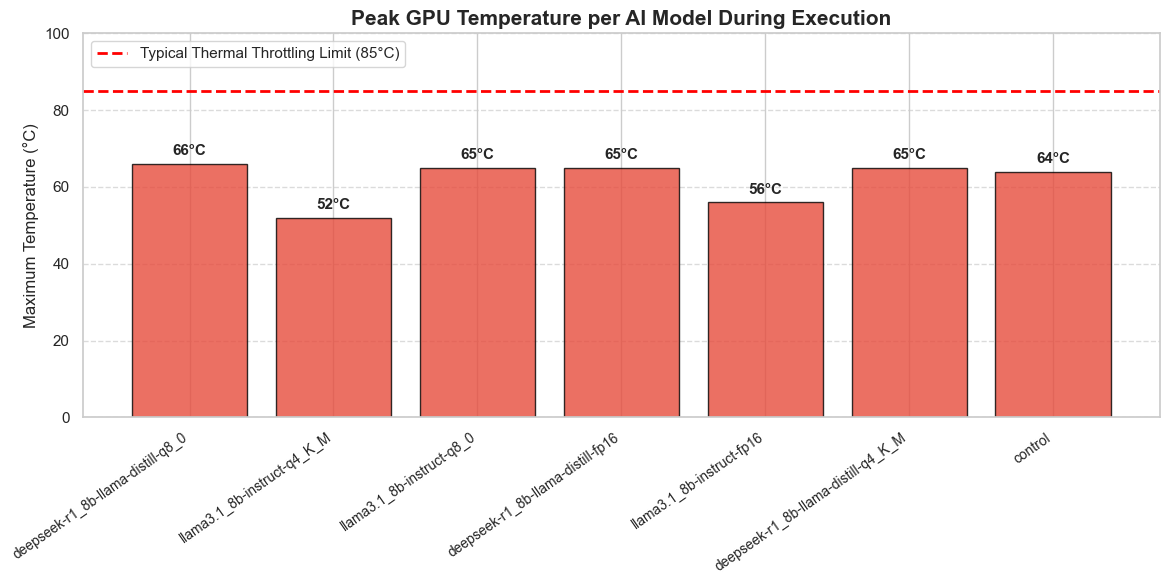

In [71]:
print("Scanning temperature sensors across all trials...")

max_temps = {}
global_max = 0

# Loop through every single CSV and extract the maximum temperature
for folder in model_folders:
    csv_files = glob.glob(os.path.join(base_dir, folder, "trial-*.csv"))
    folder_max = 0
    
    for file in csv_files:
        try:
            df = pd.read_csv(file)
            if 'GPU0_TEMPERATURE' in df.columns:
                trial_max = df['GPU0_TEMPERATURE'].max()
                
                # Update the max for this specific model
                if trial_max > folder_max:
                    folder_max = trial_max
                
                # Update the absolute global max
                if trial_max > global_max:
                    global_max = trial_max
        except Exception:
            continue
            
    max_temps[folder] = folder_max

# Print the final conclusive statement
print(f"\nThe absolute Maximum GPU Temperature recorded was {global_max}°C.")
if global_max <= 66:
    print("Conclusion Validated: Thermal throttling was successfully prevented.")

# Visual proof for the report
plt.figure(figsize=(12, 6))
bars = plt.bar(max_temps.keys(), max_temps.values(), color='#e74c3c', edgecolor='black', alpha=0.8)

plt.axhline(y=85, color='red', linestyle='--', linewidth=2, label='Typical Thermal Throttling Limit (85°C)')

plt.title("Peak GPU Temperature per AI Model During Execution", fontsize=15, fontweight='bold')
plt.ylabel("Maximum Temperature (°C)", fontsize=12)
plt.xticks(rotation=35, ha='right', fontsize=10)

plt.ylim(0, 100) 
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(loc='upper left')

# Add the exact temperature number on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 1.5, f"{int(yval)}°C", ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

## Exploratory Data Analysis

/var/folders/2n/l5k67t1n04s7fbzz55h9cg7r0000gn/T/ipykernel_77665/2932741958.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


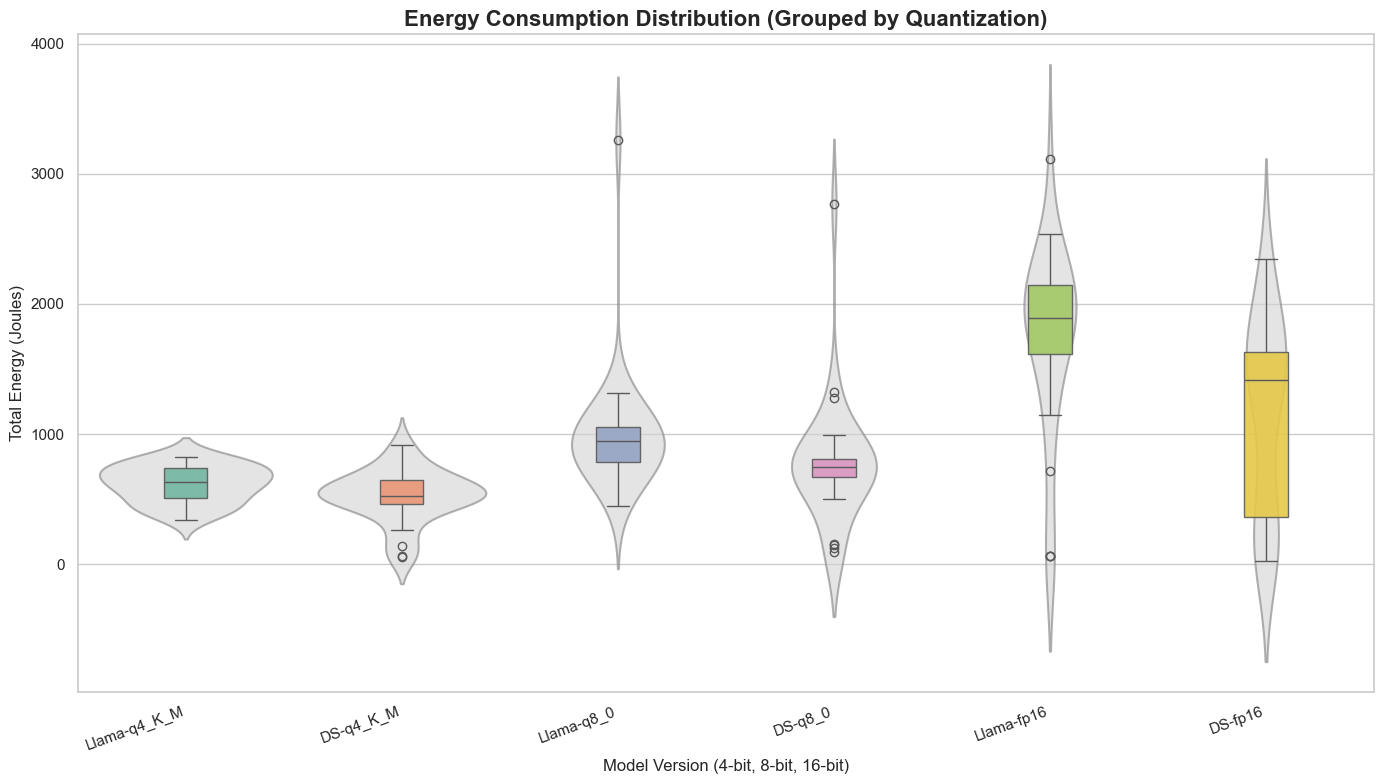

In [72]:
plot_df = clean_df[clean_df['Model'] != 'control'].copy()

# Shorten the names to make the X-axis readable
plot_df['Model_Short'] = plot_df['Model'].str.replace('deepseek-r1_8b-llama-distill-', 'DS-')
plot_df['Model_Short'] = plot_df['Model_Short'].str.replace('llama3.1_8b-instruct-', 'Llama-')

# We group 4-bit together, then 8-bit, then 16-bit
quantization_order = [
    'Llama-q4_K_M', 'DS-q4_K_M', 
    'Llama-q8_0',   'DS-q8_0', 
    'Llama-fp16',   'DS-fp16'
]

plt.figure(figsize=(14, 8))
sns.set_theme(style="whitegrid")

# Create the Violin Plot, passing the new order
sns.violinplot(
    x='Model_Short', 
    y='Total_Energy_Joules', 
    data=plot_df, 
    order=quantization_order,
    inner=None, 
    color="lightgray", 
    linewidth=1.5,
    alpha=0.6
)

# Overlay the Box Plot, passing the SAME order so they align perfectly
sns.boxplot(
    x='Model_Short', 
    y='Total_Energy_Joules', 
    data=plot_df, 
    order=quantization_order, 
    width=0.2, 
    boxprops={'zorder': 2, 'alpha': 0.9},
    palette="Set2" 
)

plt.title("Energy Consumption Distribution (Grouped by Quantization)", fontsize=16, fontweight='bold')
plt.xlabel("Model Version (4-bit, 8-bit, 16-bit)", fontsize=12)
plt.ylabel("Total Energy (Joules)", fontsize=12)

plt.xticks(rotation=20, ha='right', fontsize=11)

plt.tight_layout()
plt.show()

## Shapiro - Wilk test & T-test for Normal or Mann-Whitney U Test for not Normal

In [79]:
# Define the pairs we want to compare in a list
model_pairs = [
    ('llama3.1_8b-instruct-q4_K_M', 'deepseek-r1_8b-llama-distill-q4_K_M', '4-bit'),
    ('llama3.1_8b-instruct-q8_0', 'deepseek-r1_8b-llama-distill-q8_0', '8-bit'),
    ('llama3.1_8b-instruct-fp16', 'deepseek-r1_8b-llama-distill-fp16', '16-bit')
]

for llama_name, ds_name, precision in model_pairs:
    print(f"======================================================")
    print(f"=== STATISTICAL SIGNIFICANCE TEST: {precision.upper()} MODELS ===")
    print(f"======================================================\n")
    
    # Isolate the data for the current pair
    llama_data = clean_df[clean_df['Model'] == llama_name]['Total_Energy_Joules']
    ds_data = clean_df[clean_df['Model'] == ds_name]['Total_Energy_Joules']
    
    # 1. The Normality Test (Shapiro-Wilk)
    stat_l, p_l = stats.shapiro(llama_data)
    stat_d, p_d = stats.shapiro(ds_data)
    
    print(f"Shapiro-Wilk p-value (Llama): {p_l:.5f}")
    print(f"Shapiro-Wilk p-value (DeepSeek): {p_d:.5f}")
    
    # 2. Choose the right test dynamically based on the Professor's rules
    if p_l > 0.05 and p_d > 0.05:
        print("-> Both p-values are > 0.05. The data IS normally distributed.")
        print("-> Action: Using the Parametric Welch's T-Test.\n")
        stat_val, p_value = stats.ttest_ind(llama_data, ds_data, equal_var=False)
        test_name = "Welch's T-Test"
        
        # Use Means for the Effect Size since data is normal
        val_llama = llama_data.mean()
        val_ds = ds_data.mean()
        metric_name = "Mean"
    else:
        print("-> At least one p-value is < 0.05. The data is NOT normally distributed.")
        print("-> Action: Using the Non-Parametric Mann-Whitney U Test.\n")
        stat_val, p_value = stats.mannwhitneyu(llama_data, ds_data, alternative='two-sided')
        test_name = "Mann-Whitney U Test"
        
        # Use Medians for the Effect Size since data is heavily skewed
        val_llama = llama_data.median()
        val_ds = ds_data.median()
        metric_name = "Median"
        
    # 3. Print Final Significance
    print(f"{test_name} p-value: {p_value:.5e}")
    if p_value < 0.05:
        print(f"-> CONCLUSION: The energy difference between the {precision} models is STATISTICALLY SIGNIFICANT.\n")
    else:
        print(f"-> CONCLUSION: The difference is not statistically significant (just random noise).\n")

    # 4. Effect Size (Percentage Change)
    percent_diff = ((val_llama - val_ds) / val_llama) * 100

    print("=== EFFECT SIZE (PERCENTAGE CHANGE) ===")
    print(f"Llama {metric_name} Energy: {val_llama:.1f} Joules")
    print(f"DeepSeek {metric_name} Energy: {val_ds:.1f} Joules")
    
    if percent_diff > 0:
        print(f"✅ RESULT: DeepSeek is {percent_diff:.1f}% MORE ENERGY EFFICIENT than Llama.\n\n")
    else:
        print(f"✅ RESULT: Llama is {abs(percent_diff):.1f}% MORE ENERGY EFFICIENT than DeepSeek.\n\n")

=== STATISTICAL SIGNIFICANCE TEST: 4-BIT MODELS ===

Shapiro-Wilk p-value (Llama): 0.22881
Shapiro-Wilk p-value (DeepSeek): 0.05476
-> Both p-values are > 0.05. The data IS normally distributed.
-> Action: Using the Parametric Welch's T-Test.

Welch's T-Test p-value: 4.68132e-02
-> CONCLUSION: The energy difference between the 4-bit models is STATISTICALLY SIGNIFICANT.

=== EFFECT SIZE (PERCENTAGE CHANGE) ===
Llama Mean Energy: 616.2 Joules
DeepSeek Mean Energy: 522.1 Joules
✅ RESULT: DeepSeek is 15.3% MORE ENERGY EFFICIENT than Llama.


=== STATISTICAL SIGNIFICANCE TEST: 8-BIT MODELS ===

Shapiro-Wilk p-value (Llama): 0.00000
Shapiro-Wilk p-value (DeepSeek): 0.00001
-> At least one p-value is < 0.05. The data is NOT normally distributed.
-> Action: Using the Non-Parametric Mann-Whitney U Test.

Mann-Whitney U Test p-value: 1.68164e-03
-> CONCLUSION: The energy difference between the 8-bit models is STATISTICALLY SIGNIFICANT.

=== EFFECT SIZE (PERCENTAGE CHANGE) ===
Llama Median Energy